<a href="https://colab.research.google.com/github/lanpty58/mystudy/blob/main/Softmax_Regression_Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!gdown --id 1e1uIwcJ1-MviSn9yk_ldPGffDWVp6yK_

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e1uIwcJ1-MviSn9yk_ldPGffDWVp6yK_
To: /content/twitter_sentiment_analysis_3cls_dataset.zip
100% 7.97M/7.97M [00:00<00:00, 26.5MB/s]


In [ ]:
!unzip /content/twitter_sentiment_analysis_3cls_dataset.zip

Archive:  /content/twitter_sentiment_analysis_3cls_dataset.zip
  inflating: Twitter_Data.csv        


In [ ]:
dataset_path = '/content/Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
#Remove null data
df = df.dropna()

In [ ]:
def text_normalize(text):
  #Lowercasing
  text = text.lower()

  #Retweet old acronym 'RT' removal
  text = re.sub(r'~rt[\s]+','', text)

  # Hyperlinks removal
  text = re.sub(r'http?:\/\/.*[\r\n]*','', text)

   #Punctuation removal
  text = re.sub(r'[~\w\s]', '', text)

  #Remove stopwords
  stop_words = set(stopwords.words('english'))
  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  #Stemming
  stemmer = SnowballStemmer('english')
  words = text.split()
  words = [stemmer.stem(word) for word in words]
  text = ' '.join(words)


In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [ ]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis = 1)

In [ ]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() +1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

In [ ]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_b, y_encoded, test_size= val_size, random_state=random_state, shuffle = is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = test_size, random_state = random_state, shuffle = is_shuffle)


In [51]:
def softmax(z):
  exp_z = np.exp(z)
  return exp_z/exp_z.sum(axis = 1)[:, None]

def compute_loss(y_h, y):
  n = y.size
  return (-1/n)*np.sum(y*np.log(y_h))

def predict(X, theta):
  z = np.dot(X, theta)
  y_h = softmax(z)
  return y_h

def compute_gradient(X, y, y_h):
  n = y.size
  return np.dot(X.T, (y_h - y))/n

def update_theta(theta, gradient, lr):
  return theta - lr*gradient

def compute_accuracy(X, y, theta):
  y_h = predict(X, theta)
  acc = (np.argmax(y_h, axis = 1) == np.argmax(y, axis =1)).mean()
  return acc

In [52]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]
np.random.seed(random_state)
theta = np.random.uniform(size = (n_features, n_classes))

In [53]:
# Training
train_accs = []
train_losses = []
val_accs = []
val_losses = []
for epoch in range(epochs):
  batch_train_accs = []
  batch_train_losses = []
  batch_val_accs = []
  batch_val_losses = []
  for i in range(0, X_train.shape[0], batch_size):
    X_i, y_i = X_train[i: i+batch_size], y_train[i: i+batch_size]
    y_h = predict(X_i, theta)
    loss = compute_loss(y_h, y_i)
    batch_train_losses.append(loss)
    acc = compute_accuracy(X_train, y_train, theta)
    batch_train_accs.append(acc)
    gradient = compute_gradient(X_i, y_i, y_h)
    theta = update_theta(theta,gradient, lr)

    # val dataset
    y_h = predict(X_val, theta)
    loss = compute_loss(y_h, y_val)
    batch_val_losses.append(loss)
    acc = compute_accuracy(X_val, y_val, theta)
    batch_val_accs.append(acc)

  train_loss = sum(batch_train_losses)/len(batch_train_losses)
  train_losses.append(train_loss)
  train_acc = sum(batch_train_accs)/len(batch_train_accs)
  train_accs.append(train_acc)
  val_loss = sum(batch_val_losses)/len(batch_val_losses)
  val_losses.append(val_loss)
  val_acc = sum(batch_val_accs)/len(batch_val_accs)
  val_accs.append(val_acc)

  print(f'\nEPOCH {epoch +1}:\t Training loss: {train_loss: .3f} \t Validation loss: {val_loss: .3f} \t Train Acc: {train_acc: .3f} \t Val Acc: {val_acc: .3f}')



EPOCH 1:	 Training loss:  0.377 	 Validation loss:  0.376 	 Train Acc:  0.362 	 Val Acc:  0.367

EPOCH 2:	 Training loss:  0.377 	 Validation loss:  0.376 	 Train Acc:  0.363 	 Val Acc:  0.368

EPOCH 3:	 Training loss:  0.377 	 Validation loss:  0.376 	 Train Acc:  0.365 	 Val Acc:  0.369

EPOCH 4:	 Training loss:  0.376 	 Validation loss:  0.375 	 Train Acc:  0.366 	 Val Acc:  0.370

EPOCH 5:	 Training loss:  0.376 	 Validation loss:  0.375 	 Train Acc:  0.367 	 Val Acc:  0.372

EPOCH 6:	 Training loss:  0.376 	 Validation loss:  0.375 	 Train Acc:  0.368 	 Val Acc:  0.373

EPOCH 7:	 Training loss:  0.375 	 Validation loss:  0.374 	 Train Acc:  0.369 	 Val Acc:  0.374

EPOCH 8:	 Training loss:  0.375 	 Validation loss:  0.374 	 Train Acc:  0.370 	 Val Acc:  0.375

EPOCH 9:	 Training loss:  0.375 	 Validation loss:  0.374 	 Train Acc:  0.371 	 Val Acc:  0.376

EPOCH 10:	 Training loss:  0.374 	 Validation loss:  0.373 	 Train Acc:  0.373 	 Val Acc:  0.377

EPOCH 11:	 Training loss:  0

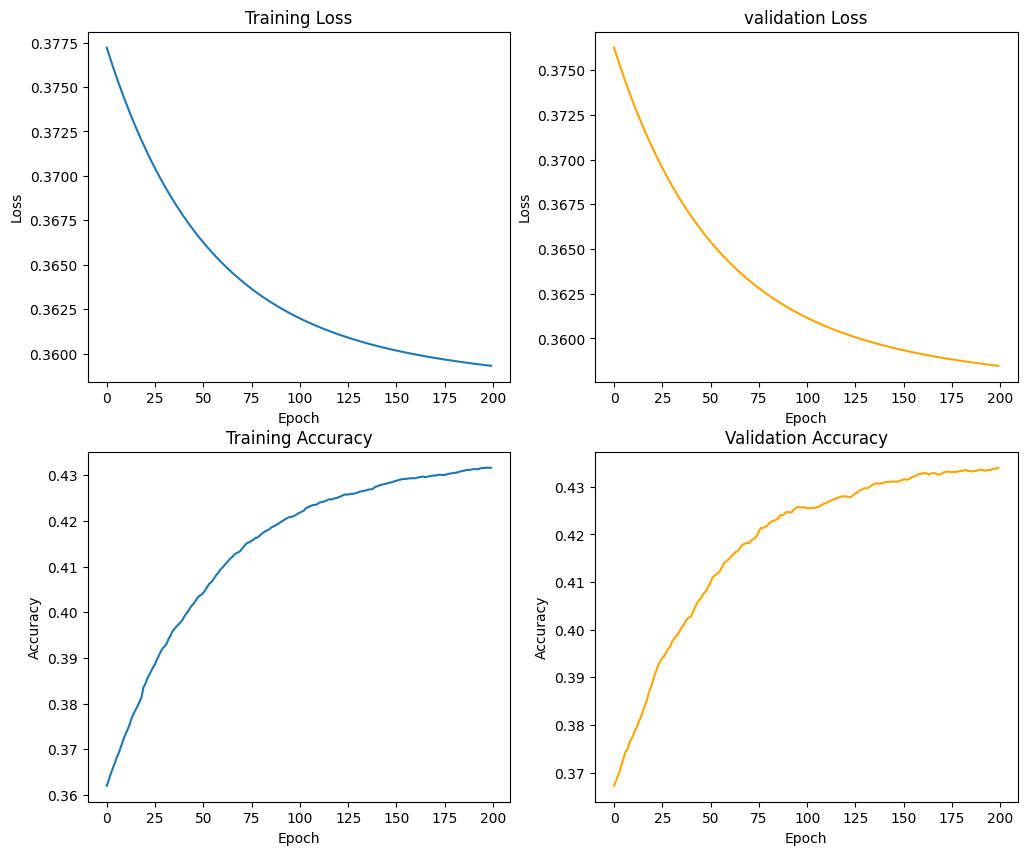

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 1].set_title('validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel = 'Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 1].set_title('Validation Accuracy')
plt.show()

In [56]:
# Evaluation
val_acc = compute_accuracy(X_val, y_val, theta)
val_acc


0.4340369393139842

In [57]:
#Test Acc
test_acc = compute_accuracy(X_test, y_test, theta)
test_acc

0.4322881511934712